In [1]:
from multiprocessing import Pool, cpu_count

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from abstraction import AbstractionLearner, ActionEmbeddingModel
from dataset import ExtremeBanditDataset
from policy import gen_eps_greedy
from estimator import InversePropensityScore as IPS
from estimator import MarginalizedIPS as MIPS
from util import (
    ActionEmbedOffPolicyEvaluation, 
    aggregate_simulation_results, 
    visualize_mean_squared_error
)


/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# setting

# 変数
val_sizes = [500, 2000, 3500, 5000]

# 定数
dataset_name = "EUR-Lex4K"
n_sim = 100
eps = 0.3
ope_estimators = [IPS(estimator_name="IPS"), MIPS(estimator_name="MIPS (true)")]
random_state = 12345
dim_context = 10

### Abstraction setting

hidden_size=5
n_cat_dim=3
n_cat_per_dim=7
learning_rate=0.001
num_epochs=10
batch_size=10
weight_decay=0.01
is_discrete=True

number of action: 3956


Training Abstraction Model: 100% 10/10 [01:02<00:00,  6.25s/it]


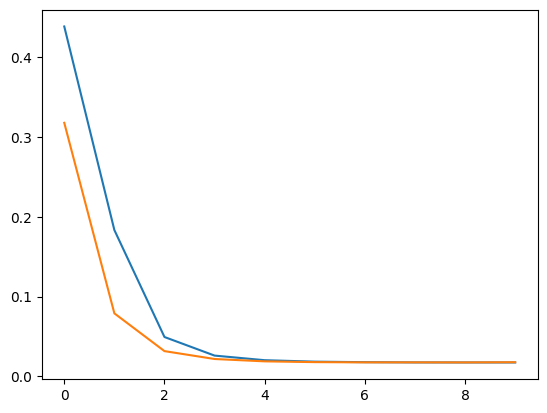

Text(0.5, 1.0, 'loss of abstraction model')

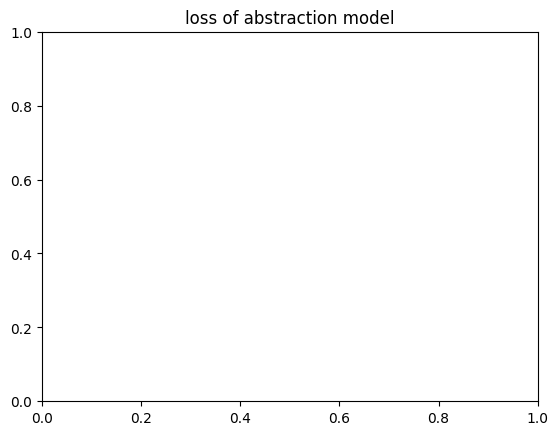

In [3]:
# experiment with "EUR-Lex4K" dataset contained in the Extreme Classification Repository.

dataset = ExtremeBanditDataset(dataset_name=dataset_name, random_state=random_state, n_components=dim_context)
print(f"number of action: {dataset.train_expected_rewards.shape[1]}")

action_dist = gen_eps_greedy(expected_reward=dataset.train_expected_rewards, eps=eps)
policy_value = dataset.calc_ground_truth_policy_value(expected_reward=dataset.train_expected_rewards, action_dist=action_dist)

## train a abstraction to obtain action embeddings
learner = AbstractionLearner(
    model=ActionEmbeddingModel(dim_context=dim_context, n_actions=dataset.n_actions, hidden_size=hidden_size, n_cat_dim=n_cat_dim),
    hidden_size=hidden_size,
    n_cat_dim=n_cat_dim,
    n_cat_per_dim=n_cat_per_dim,
    learning_rate=learning_rate,
    num_epochs=num_epochs,
    batch_size=batch_size,
    weight_decay=weight_decay,
    is_discrete=is_discrete
)

learner.fit(context=dataset.test_contexts, action=dataset.test_label)
unique_action_context = learner.obtain_action_embedding()

plt.title('loss of abstraction model')
plt.plot(learner.train_loss)
plt.plot(learner.val_loss)
plt.show()

In [4]:
result_df_list = []
for val_size in val_sizes:
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"val_size={val_size}..."):
        
        # generate semi-synthetic data
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        val_data["action_context"] = unique_action_context[val_data["action"]]
        val_data["unique_action_context"] = unique_action_context

        # evaluation policy
        action_dist = gen_eps_greedy(expected_reward=val_data["expected_reward"], eps=eps)
        
        # off policy evaluation
        ope = ActionEmbedOffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
        )
        estimated_policy_values = ope.estimate_policy_values(action_dist=action_dist)
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=val_size
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

val_size=500...: 100% 100/100 [00:30<00:00,  3.24it/s]
val_size=2000...: 100% 100/100 [02:28<00:00,  1.49s/it]
val_size=3500...: 100% 100/100 [04:09<00:00,  2.49s/it]
val_size=5000...: 100% 100/100 [06:02<00:00,  3.62s/it]


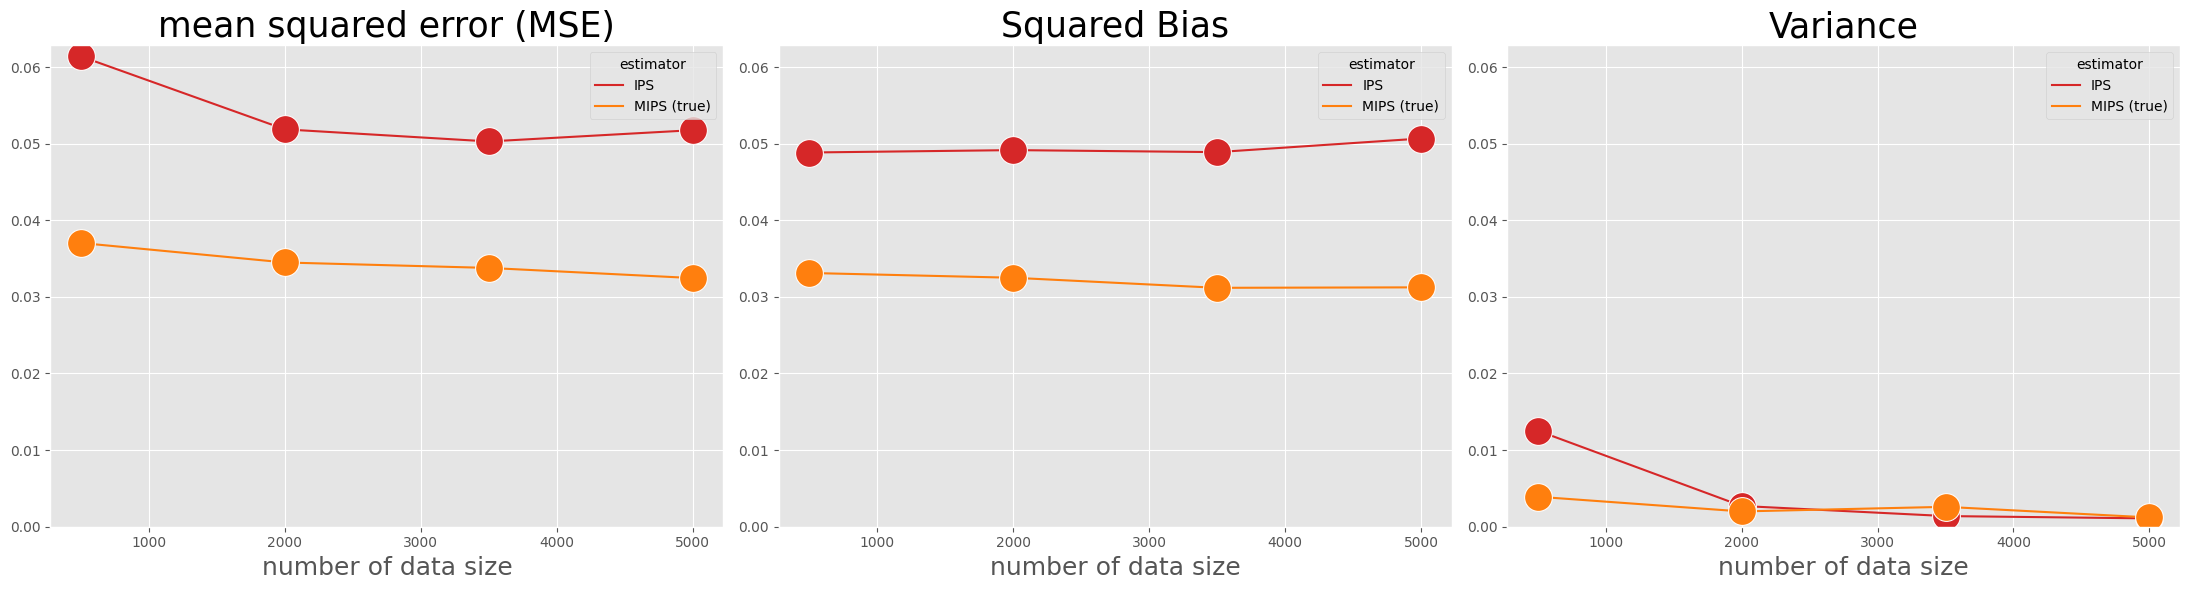

In [5]:
visualize_mean_squared_error(result_df=result_df, xlabel="number of data size")

In [ ]:
# setting 2

# 変数
val_sizes = [500, 2000, 3500, 5000]

# 定数
dataset_name = "Wiki10-31K"
n_sim = 100
eps = 0.3
ope_estimators = [IPS(estimator_name="IPS"), MIPS(estimator_name="MIPS (true)")]
random_state = 12345
dim_context = 10

### Abstraction setting

hidden_size=5,
n_cat_dim=3,
n_cat_per_dim=7,
learning_rate=0.001,
num_epochs=10,
batch_size=10,
weight_decay=0.01,
is_discrete=True

In [ ]:
# experiment with "Wiki10-31K" dataset contained in the Extreme Classification Repository.

dataset = ExtremeBanditDataset(dataset_name=dataset_name, random_state=random_state, n_components=dim_context)
print(f"number of action: {dataset.train_expected_rewards.shape[1]}")

action_dist = gen_eps_greedy(expected_reward=dataset.train_expected_rewards, eps=eps)
policy_value = dataset.calc_ground_truth_policy_value(expected_reward=dataset.train_expected_rewards, action_dist=action_dist)

## train a abstraction to obtain action embeddings
learner = AbstractionLearner(
    model=ActionEmbeddingModel(dim_context=dim_context, n_actions=dataset.n_actions, hidden_size=hidden_size, n_cat_dim=n_cat_dim),
    hidden_size=hidden_size,
    n_cat_dim=n_cat_dim,
    n_cat_per_dim=n_cat_per_dim,
    learning_rate=learning_rate,
    num_epochs=num_epochs,
    batch_size=batch_size,
    weight_decay=weight_decay,
    is_discrete=is_discrete
)

learner.fit(context=dataset.test_contexts, action=dataset.test_label)
unique_action_context = learner.obtain_action_embedding()

plt.plot(learner.train_loss)
plt.plot(learner.val_loss)
plt.show()
plt.title('loss of abstraction model')

In [ ]:
result_df_list = []
for val_size in val_sizes:
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"val_size={val_size}..."):
        
        # generate semi-synthetic data
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        val_data["action_context"] = unique_action_context[val_data["action"]]
        val_data["unique_action_context"] = unique_action_context

        # evaluation policy
        action_dist = gen_eps_greedy(expected_reward=val_data["expected_reward"], eps=eps)
        
        # off policy evaluation
        ope = ActionEmbedOffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
        )
        estimated_policy_values = ope.estimate_policy_values(action_dist=action_dist)
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=val_size
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

In [ ]:
visualize_mean_squared_error(result_df=result_df, xlabel="number of data size")